 # Temporal Correlation

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import pickle
import time

np.random.seed(19)
DATA_DIR = 'data/'
PICKLE_DIR = 'pickles/'
DAYS_TO_MINUTES = 24*60
DATA_TYPES = {'CPU', 'MEM'}


In [31]:
DATA = dict()
SAMPLES = dict()


In [32]:
for data_type in DATA_TYPES:
    if data_type not in DATA:
        DATA[data_type] = np.load(DATA_DIR + data_type + '.npy')
        np.random.shuffle(DATA[data_type])

second_data_type = None
for first_data_type in DATA:
    if second_data_type is not None:
        assert DATA[first_data_type].shape == DATA[second_data_type].shape
    second_data_type = first_data_type

assert second_data_type is not None
NO_OF_MACHINES = DATA[second_data_type].shape[0]
NO_OF_TIMESTAMPS = DATA[second_data_type].shape[1]
SAMPLE_SIZE = NO_OF_MACHINES//10

SAMPLES = dict()
for data_type in DATA:
    SAMPLES[data_type] = DATA[data_type][:SAMPLE_SIZE]


In [33]:
try:
    raise FileNotFoundError
    pickle_in = open(PICKLE_DIR+"temporal_correlations.pickle", "rb")
    TEMPORAL_CORRELATIONS = pickle.load(pickle_in)
except FileNotFoundError:
    print('here')
    CPU_TEMPORAL_CORRELATIONS = np.full(
        (SAMPLE_SIZE, 2*NO_OF_TIMESTAMPS-1), np.nan)
    MEM_TEMPORAL_CORRELATIONS = np.full(
        (SAMPLE_SIZE, 2*NO_OF_TIMESTAMPS-1), np.nan)
    TEMPORAL_CORRELATIONS = {
        'CPU': CPU_TEMPORAL_CORRELATIONS, 'MEM': MEM_TEMPORAL_CORRELATIONS}


here


In [40]:
def ccf(x, y, no_lag=False):
    '''Normalized cross-correlation function,
    similar to ccf in the R language.
    
    Parameters:
    x -- first time series
    y --  second time series
    
    Optional:
    no_lag -- False by default. If true, return a list with every time-shift
        possible instead.
    
    Returns:
        A float with 0 time-shift or a list of floats that represent the
        cross-correlation for every possible time-shift.
    '''
    if np.std(y) * np.std(x) == 0:
        return 0
    else:
        correlation = (
            np.correlate(y - np.mean(y), x - np.mean(x))
            if no_lag else ss.correlate(y - np.mean(y), x - np.mean(x)))
        n = NO_OF_TIMESTAMPS
        return (
            correlation / (np.std(y) * np.std(x) * len(y))
            if no_lag else
            correlation / (np.std(y) * np.std(x) * np.array([n - abs(n-i) for i in range(1, 2*n)])))


 Calculate the temporal correlation of each time series with itself,
 at every possible time-shift.

In [41]:
for i in range(SAMPLE_SIZE):
    for data_type in DATA_TYPES:
        TEMPORAL_CORRELATIONS[data_type][i] = ccf(
            SAMPLES[data_type][i],
            SAMPLES[data_type][i])
pickle_out = open(PICKLE_DIR+"temporal_correlations.pickle", "wb")
pickle.dump(TEMPORAL_CORRELATIONS, pickle_out)
pickle_out.close()


 Have a look at the average temporal correlation for each time shift.

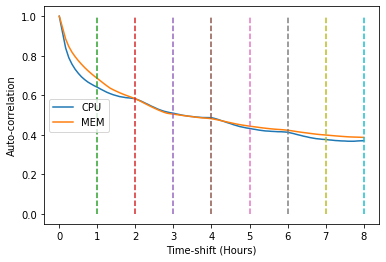

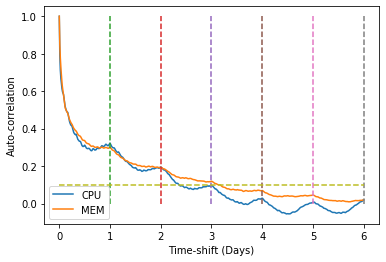

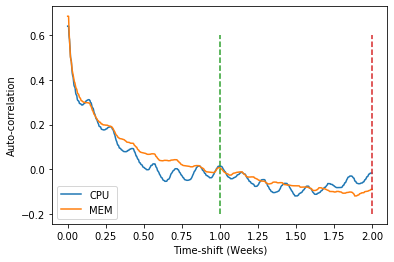

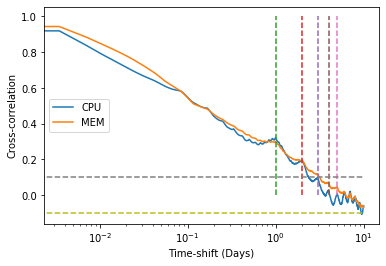

In [79]:
i = 1
zero_shift_timestamp = NO_OF_TIMESTAMPS-1
DAYS_TO_MINUTES = 24*60
minute_vertical_range = [0, 1]
daily_vertical_range = [0, 1]
weekly_vertical_range = [-0.2, 0.6]


avg_correlation_cpu = np.average(TEMPORAL_CORRELATIONS['CPU'], axis=0)
avg_correlation_mem = np.average(TEMPORAL_CORRELATIONS['MEM'], axis=0)

# One unit of time equals 5 minutes.
time_window = (
    zero_shift_timestamp,
    zero_shift_timestamp + 8 * 60 // 5 + 1)
fig, ax = plt.subplots()
ax.plot(
    [5 * (x - zero_shift_timestamp) / 60
        for x in range(len(avg_correlation_cpu))][time_window[0]:time_window[1]],
    avg_correlation_cpu[time_window[0]:time_window[1]], '-', label='CPU')
ax.plot(
    # One unit of time equals 5 minutes.
    [5 * (x - zero_shift_timestamp) / 60
        for x in range(len(avg_correlation_mem))][time_window[0]:time_window[1]],
    avg_correlation_mem[time_window[0]:time_window[1]], '-', label='MEM')
ax.plot(
    # +/- a few days
    2*[1], daily_vertical_range, '--',
    2*[2], daily_vertical_range, '--',
    2*[3], daily_vertical_range, '--',
    2*[4], daily_vertical_range, '--',
    2*[5], daily_vertical_range, '--',
    2*[6], daily_vertical_range, '--',
    2*[7], daily_vertical_range, '--',
    2*[8], daily_vertical_range, '--')
plt.xlabel('Time-shift (Hours)')
plt.ylabel('Auto-correlation')
plt.legend()
plt.show()


# Demonstrate daily periodicity.

# One unit of time equals 5 minutes.
time_window = (
    zero_shift_timestamp,
    zero_shift_timestamp + 6 * DAYS_TO_MINUTES // 5 + 1)
fig, ax = plt.subplots()
ax.plot(
    # One unit of time equals 5 minutes.
    [5 * (x - zero_shift_timestamp) / DAYS_TO_MINUTES
        for x in range(len(avg_correlation_cpu))][time_window[0]:time_window[1]],
    avg_correlation_cpu[time_window[0]:time_window[1]], '-', label='CPU')
ax.plot(
    [5 * (x - zero_shift_timestamp) / DAYS_TO_MINUTES
        for x in range(len(avg_correlation_mem))][time_window[0]:time_window[1]],
    avg_correlation_mem[time_window[0]:time_window[1]], '-', label='MEM')
ax.plot(
    # +/- a few days
    2*[1], daily_vertical_range, '--',
    2*[2], daily_vertical_range, '--',
    2*[3], daily_vertical_range, '--',
    2*[4], daily_vertical_range, '--',
    2*[5], daily_vertical_range, '--',
    2*[6], daily_vertical_range, '--',
    [0, 6], 2*[0.1], '--')
plt.xlabel('Time-shift (Days)')
plt.ylabel('Auto-correlation')
plt.legend()
plt.show()

# Demonstrate weekly periodicity.

# One unit of time equals 5 minutes.
time_window = (
    zero_shift_timestamp,
    zero_shift_timestamp + 2 * 7 * DAYS_TO_MINUTES // 5 + 1)
smoothed_cpu = ss.medfilt(avg_correlation_cpu, kernel_size=49)
smoothed_mem = ss.medfilt(avg_correlation_mem, kernel_size=49)
fig, ax = plt.subplots()
ax.plot(
    # One unit of time equals 5 minutes.
    [5 * (x - zero_shift_timestamp) / (7 * DAYS_TO_MINUTES)
        for x in range(len(smoothed_cpu))][time_window[0]:time_window[1]],
    smoothed_cpu[time_window[0]:time_window[1]], '-', label='CPU')
ax.plot(
    [5 * (x - zero_shift_timestamp) / (7 * DAYS_TO_MINUTES)
        for x in range(len(smoothed_mem))][time_window[0]:time_window[1]],
    smoothed_mem[time_window[0]:time_window[1]], '-', label='MEM')
ax.plot(
    # +/- a few weeks
    2*[1], weekly_vertical_range, '--',
    2*[2], weekly_vertical_range, '--')
plt.xlabel('Time-shift (Weeks)')
plt.ylabel('Auto-correlation')
plt.legend()
plt.show()


time_window = (
    zero_shift_timestamp,
    zero_shift_timestamp + 10 * DAYS_TO_MINUTES // 5 + 1)
fig, ax = plt.subplots()
ax.plot(
    # One unit of time equals 5 minutes.
    [5 * (x - zero_shift_timestamp) / DAYS_TO_MINUTES
        for x in range(len(avg_correlation_cpu))][time_window[0]:time_window[1]],
    avg_correlation_cpu[time_window[0]:time_window[1]], '-', label='CPU')
ax.plot(
    [5 * (x - zero_shift_timestamp) / DAYS_TO_MINUTES
        for x in range(len(avg_correlation_mem))][time_window[0]:time_window[1]],
    avg_correlation_mem[time_window[0]:time_window[1]], '-', label='MEM')
ax.plot(
    # +/- a few days
    2*[1], daily_vertical_range, '--',
    2*[2], daily_vertical_range, '--',
    2*[3], daily_vertical_range, '--',
    2*[4], daily_vertical_range, '--',
    2*[5], daily_vertical_range, '--',
    [0, 10], 2*[0.1], '--',
    [0, 10], 2*[-0.1], '--')
plt.xlabel('Time-shift (Days)')
plt.ylabel('Cross-correlation')
plt.xscale('log')
plt.legend()
plt.show()
i += 1



In [0]:
for data_type in TEMPORAL_CORRELATIONS:
    avg_correlation = np.average(TEMPORAL_CORRELATIONS[data_type], axis=0)
    print(data_type, 'Average Correlation:', np.average(avg_correlation))
    print(data_type, 'RMS Correlation:',
          np.sqrt(np.mean(avg_correlation**2)))
    plt.hist(avg_correlation, bins=[n/10 for n in range(-10, 11)])
    plt.title(data_type + ' Temporal Correlations')
    plt.show()


In [0]:
for data_type in TEMPORAL_CORRELATIONS:
    avg_correlation = np.average(TEMPORAL_CORRELATIONS[data_type], axis=0)
    daily_timestamps = (
        [zero_shift_timestamp + n * DAYS_TO_MINUTES // 5 for n in range(-1, 2)])
    daily_timestamps = daily_timestamps[:1] + daily_timestamps [2:]
    daily_corr = np.array(
        [avg_correlation[timestamp] for timestamp in daily_timestamps])
        
    print(data_type, 'Average Correlation:', np.average(daily_corr))
    print(data_type, 'RMS Correlation:',
          np.sqrt(np.mean(daily_corr**2)))
    plt.hist(daily_corr, bins=[n/10 for n in range(-10, 11)])
    plt.title(data_type + ' Temporal Correlations')
    plt.show()

#------------------------------------------------------------------

In [43]:
def ccf(x, y, no_lag=False):
    if np.std(y) * np.std(x) == 0:
        return 0
    else:
        correlation = (
            np.correlate(y - np.mean(y), x - np.mean(x))
            if no_lag else ss.correlate(y - np.mean(y), x - np.mean(x)))
        n = NO_OF_TIMESTAMPS
        return (
            correlation / (np.std(y) * np.std(x) * len(y))
            if no_lag else
            correlation / (np.std(y) * np.std(x) * (np.array([n - abs(n-i) for i in range(1, 2*n)]))))
norm = {
    'CPU': np.full((SAMPLE_SIZE, 2*NO_OF_TIMESTAMPS-1), np.nan),
    'MEM': np.full((SAMPLE_SIZE, 2*NO_OF_TIMESTAMPS-1), np.nan)}
for i in range(SAMPLE_SIZE):
    for data_type in DATA_TYPES:
        norm[data_type][i] = ccf(
            SAMPLES[data_type][i],
            SAMPLES[data_type][i])
def ccf(x, y, no_lag=False):
    if np.std(y) * np.std(x) == 0:
        return 0
    else:
        correlation = (
            np.correlate(y - np.mean(y), x - np.mean(x))
            if no_lag else ss.correlate(y - np.mean(y), x - np.mean(x)))
        n = NO_OF_TIMESTAMPS
        return (
            correlation / (np.std(y) * np.std(x) * len(y))
            if no_lag else
            n * correlation / (np.array([n - abs(n-i) for i in range(1, 2*n)])))
no_effects = {
    'CPU': np.full((SAMPLE_SIZE, 2*NO_OF_TIMESTAMPS-1), np.nan),
    'MEM': np.full((SAMPLE_SIZE, 2*NO_OF_TIMESTAMPS-1), np.nan)}
for i in range(SAMPLE_SIZE):
    for data_type in DATA_TYPES:
        no_effects[data_type][i] = ccf(
            SAMPLES[data_type][i],
            SAMPLES[data_type][i])
def ccf(x, y, no_lag=False):
    if np.std(y) * np.std(x) == 0:
        return 0
    else:
        correlation = (
            np.correlate(y - np.mean(y), x - np.mean(x))
            if no_lag else ss.correlate(y - np.mean(y), x - np.mean(x)))
        n = NO_OF_TIMESTAMPS
        return (
            correlation / (np.std(y) * np.std(x) * len(y))
            if no_lag else
            correlation)
nothing = {
    'CPU': np.full((SAMPLE_SIZE, 2*NO_OF_TIMESTAMPS-1), np.nan),
    'MEM': np.full((SAMPLE_SIZE, 2*NO_OF_TIMESTAMPS-1), np.nan)}
for i in range(SAMPLE_SIZE):
    for data_type in DATA_TYPES:
        nothing[data_type][i] = ccf(
            SAMPLES[data_type][i],
            SAMPLES[data_type][i])


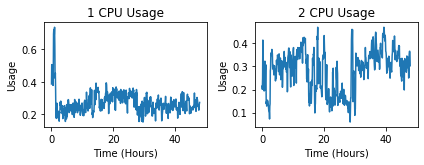

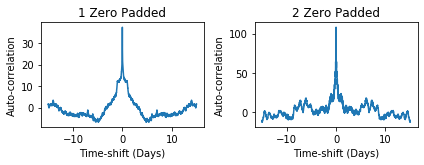

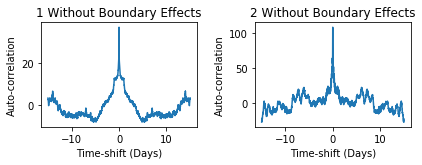

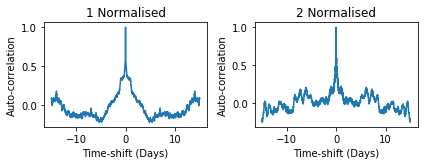

In [45]:
i = 1
zero_shift_timestamp = NO_OF_TIMESTAMPS-1
DAYS_TO_MINUTES = 24*60
minute_vertical_range = [0, 1]
daily_vertical_range = [0, 1]
weekly_vertical_range = [-0.1, 0.5]
data_type = 'CPU'
machine1 = SAMPLES[data_type][78]
machine2 = SAMPLES[data_type][38]
for signal in [machine1, machine2]:
    plt.subplot(2, 2, i).plot([5*i/60 for i in range(2*24*60//5)], signal[:2*24*60//5])
    plt.title(str((i+1)%2+1) +' '+ data_type + ' Usage')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Usage')
    i += 1
plt.tight_layout()
plt.show()
TEMPORAL_CORRELATIONS = nothing
signal1 = TEMPORAL_CORRELATIONS[data_type][78]
signal2 = TEMPORAL_CORRELATIONS[data_type][38]

i = 1
for signal in [signal1, signal2]:
    time_window = (
        zero_shift_timestamp - 15 * DAYS_TO_MINUTES // 5,
        zero_shift_timestamp + 15 * DAYS_TO_MINUTES // 5 + 1)
    plt.subplot(2, 2, i).plot(
        # One unit of time equals 5 minutes.
        [5 * (x - zero_shift_timestamp) / DAYS_TO_MINUTES
        for x in range(len(signal))][time_window[0]:time_window[1]],
        signal[time_window[0]:time_window[1]], '-',
        )
    plt.title(str((i+1)%2+1) + ' Zero Padded')
    plt.xlabel('Time-shift (Days)')
    plt.ylabel('Auto-correlation')
    i += 1
plt.tight_layout()
plt.show()
TEMPORAL_CORRELATIONS = no_effects
signal1 = TEMPORAL_CORRELATIONS[data_type][78]
signal2 = TEMPORAL_CORRELATIONS[data_type][38]
i = 1
for signal in [signal1, signal2]:
    time_window = (
        zero_shift_timestamp - 15 * DAYS_TO_MINUTES // 5,
        zero_shift_timestamp + 15 * DAYS_TO_MINUTES // 5 + 1)
    plt.subplot(2, 2, i).plot(
        # One unit of time equals 5 minutes.
        [5 * (x - zero_shift_timestamp) / DAYS_TO_MINUTES
        for x in range(len(signal))][time_window[0]:time_window[1]],
        signal[time_window[0]:time_window[1]], '-',
        )
    plt.title(str((i+1)%2+1) + ' Without Boundary Effects')
    plt.xlabel('Time-shift (Days)')
    plt.ylabel('Auto-correlation')
    i += 1
plt.tight_layout()
plt.show()
TEMPORAL_CORRELATIONS = norm
signal1 = TEMPORAL_CORRELATIONS[data_type][78]
signal2 = TEMPORAL_CORRELATIONS[data_type][38]
i = 1
for signal in [signal1, signal2]:
    time_window = (
        zero_shift_timestamp - 15 * DAYS_TO_MINUTES // 5,
        zero_shift_timestamp + 15 * DAYS_TO_MINUTES // 5 + 1)
    plt.subplot(2, 2, i).plot(
        # One unit of time equals 5 minutes.
        [5 * (x - zero_shift_timestamp) / DAYS_TO_MINUTES
        for x in range(len(signal))][time_window[0]:time_window[1]],
        signal[time_window[0]:time_window[1]], '-',
        )
    plt.title(str((i+1)%2+1) + ' Normalised')
    plt.xlabel('Time-shift (Days)')
    plt.ylabel('Auto-correlation')
    i += 1

plt.tight_layout()
plt.show()

